# Introduction


Except that, most of the code is just copy from [https://www.kaggle.com/hukuda222/tfidf-swem-approach](https://www.kaggle.com/hukuda222/tfidf-swem-approach) by @hukuda222.
This kernel is based on TFIDF+NN model(https://www.kaggle.com/ryches/tfidf-benchmark ).

> I will add new information to TFIDF+NN model(https://www.kaggle.com/ryches/tfidf-benchmark ).<br>
> TFIDF can create features based on actual vocabulary, but it can't handle well when there is another word of close meaning.<br>
> Therefore, I thought that adding SWEM(https://arxiv.org/abs/1805.09843) using learned word2vec as a feature value would increase the score.

In [5]:
import numpy as np
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import gensim
from nltk.corpus import brown
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
from keras.callbacks.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks.callbacks import EarlyStopping
from scipy.stats import spearmanr
from nltk.corpus import wordnet as wn
import tqdm
from sklearn.model_selection import StratifiedKFold

In [7]:
zf = zipfile.ZipFile('google-quest-challenge.zip') 
train = pd.read_csv(zf.open('train.csv'))
test = pd.read_csv(zf.open('test.csv'))

In [8]:
sample_sub = pd.read_csv(zf.open('sample_submission.csv'))

In [34]:
sample_sub.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,...,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,...,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,...,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [35]:
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_type_reason_explanation,answer_well_written,question_title_n_chars,question_title_n_words,question_body_n_chars,question_body_n_words,answer_n_chars,answer_n_words,num_answer_user,num_question_user
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,0.000000,1.000000,68,12,836,138,833,148,4,8
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.666667,0.888889,108,15,789,143,451,71,1,2
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,1.000000,0.888889,56,6,653,116,1048,187,4,1
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,1.000000,1.000000,37,7,425,72,1337,257,3,4
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,44,8,416,79,225,23,1,3


In [36]:
#check train, test, and sample size
print(len(train.index), len(test.index), len(sample_sub.index))

6079 476 476


In [10]:
target_cols = ['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']

# Adding simple feature



In [12]:
def char_count(s):
    return len(s)

def word_count(s):
    return s.count(' ')

train['question_title_n_chars'] = train['question_title'].apply(char_count)
train['question_title_n_words'] = train['question_title'].apply(word_count)
train['question_body_n_chars'] = train['question_body'].apply(char_count)
train['question_body_n_words'] = train['question_body'].apply(word_count)
train['answer_n_chars'] = train['answer'].apply(char_count)
train['answer_n_words'] = train['answer'].apply(word_count)

test['question_title_n_chars'] = test['question_title'].apply(char_count)
test['question_title_n_words'] = test['question_title'].apply(word_count)
test['question_body_n_chars'] = test['question_body'].apply(char_count)
test['question_body_n_words'] = test['question_body'].apply(word_count)
test['answer_n_chars'] = test['answer'].apply(char_count)
test['answer_n_words'] = test['answer'].apply(word_count)

train['question_body_n_chars'].clip(0, 5000, inplace=True)
test['question_body_n_chars'].clip(0, 5000, inplace=True)
train['question_body_n_words'].clip(0, 1000, inplace=True)
test['question_body_n_words'].clip(0, 1000, inplace=True)

train['answer_n_chars'].clip(0, 5000, inplace=True)
test['answer_n_chars'].clip(0, 5000, inplace=True)
train['answer_n_words'].clip(0, 1000, inplace=True)
test['answer_n_words'].clip(0, 1000, inplace=True)


In [13]:
num_question = train['question_user_name'].value_counts()
num_answer = train['answer_user_name'].value_counts()

train['num_answer_user'] = train['answer_user_name'].map(num_answer)
train['num_question_user'] = train['question_user_name'].map(num_question)
test['num_answer_user'] = test['answer_user_name'].map(num_answer)
test['num_question_user'] = test['question_user_name'].map(num_question)

# map is done by train data, we need to fill value for user which does not appear in train data...
test['num_answer_user'].fillna(1, inplace=True)
test['num_question_user'].fillna(1, inplace=True)

In [14]:
simple_feature_cols = [
    'question_title_n_chars', 'question_title_n_words', 'question_body_n_chars', 'question_body_n_words',
    'answer_n_chars', 'answer_n_words', 'num_answer_user', 'num_question_user'
]
simple_engineered_feature = train[simple_feature_cols].values
simple_engineered_feature_test = test[simple_feature_cols].values

In [15]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
simple_engineered_feature = scaler.fit_transform(simple_engineered_feature)
simple_engineered_feature_test = scaler.transform(simple_engineered_feature_test)

# other feature engineering

Below is just a copy of https://www.kaggle.com/hukuda222/tfidf-swem-approach

In [16]:
def simple_prepro(s):
    return [w for w in s.replace("\n"," ").replace(","," , ").replace("("," ( ").replace(")"," ) ").
            replace("."," . ").replace("?"," ? ").replace(":"," : ").replace("n't"," not").
            replace("'ve"," have").replace("'re"," are").replace("'s"," is").split(" ") if w != ""]

In [17]:
def simple_prepro_tfidf(s):
    return " ".join([w for w in s.lower().replace("\n"," ").replace(","," , ").replace("("," ( ").replace(")"," ) ").
            replace("."," . ").replace("?"," ? ").replace(":"," : ").replace("n't"," not").
            replace("'ve"," have").replace("'re"," are").replace("'s"," is").split(" ") if w != ""])

This is basic preprocessing. This time, symbols and words are attached, so they are separated here.

In [18]:
qt_max = max([len(simple_prepro(l)) for l in list(train["question_title"].values)])
qb_max = max([len(simple_prepro(l))  for l in list(train["question_body"].values)])
an_max = max([len(simple_prepro(l))  for l in list(train["answer"].values)])
print("max lenght of question_title is",qt_max)
print("max lenght of question_body is",qb_max)
print("max lenght of question_answer is",an_max)

max lenght of question_title is 35
max lenght of question_body is 3404
max lenght of question_answer is 8179


The text is so long that it is difficult to apply RNN to all series.

In [19]:
w2v_model = gensim.models.Word2Vec(brown.sents())

Here we use a trained word2vec model that is easily available with nltk.<br>
We used SWEM with max pooling.<br>

In [20]:
def get_word_embeddings(text):
    np.random.seed(abs(hash(text)) % (10 ** 8))
    words = simple_prepro(text)
    vectors = np.zeros((len(words),100))
    if len(words)==0:
        vectors = np.zeros((1,100))
    for i,word in enumerate(simple_prepro(text)):
        try:
            vectors[i]=w2v_model[word]
        except:
            vectors[i]=np.random.uniform(-0.01, 0.01,100)
            #np.array([len(text)/5000,len(words)/1000,text.count("\n")/10])]
    return np.max(np.array(vectors), axis=0)
                           

In [21]:
question_title = [get_word_embeddings(l) for l in tqdm.tqdm(train["question_title"].values)]
question_title_test = [get_word_embeddings(l) for l in tqdm.tqdm(test["question_title"].values)]

question_body = [get_word_embeddings(l) for l in tqdm.tqdm(train["question_body"].values)]
question_body_test = [get_word_embeddings(l) for l in tqdm.tqdm(test["question_body"].values)]

answer = [get_word_embeddings(l) for l in tqdm.tqdm(train["answer"].values)]
answer_test = [get_word_embeddings(l) for l in tqdm.tqdm(test["answer"].values)]

  0%|          | 0/6079 [00:00<?, ?it/s]/home/yang_jing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
100%|██████████| 476/476 [00:00<00:00, 771.93it/s]


From here on, I'm quite referring to https://www.kaggle.com/ryches/tfidf-benchmark.

In [22]:
gc.collect()
tfidf = TfidfVectorizer(ngram_range=(1, 3))
tsvd = TruncatedSVD(n_components = 50)
tfidf_question_title = tfidf.fit_transform([simple_prepro_tfidf(l) for l in tqdm.tqdm(train["question_title"].values)])
tfidf_question_title_test = tfidf.transform([simple_prepro_tfidf(l) for l in tqdm.tqdm(test["question_title"].values)])
tfidf_question_title = tsvd.fit_transform(tfidf_question_title)
tfidf_question_title_test = tsvd.transform(tfidf_question_title_test)

tfidf_question_body = tfidf.fit_transform([simple_prepro_tfidf(l) for l in tqdm.tqdm(train["question_body"].values)])
tfidf_question_body_test = tfidf.transform([simple_prepro_tfidf(l) for l in tqdm.tqdm(test["question_body"].values)])
tfidf_question_body = tsvd.fit_transform(tfidf_question_body)
tfidf_question_body_test = tsvd.transform(tfidf_question_body_test)

tfidf_answer = tfidf.fit_transform([simple_prepro_tfidf(l) for l in tqdm.tqdm(train["answer"].values)])
tfidf_answer_test = tfidf.transform([simple_prepro_tfidf(l) for l in tqdm.tqdm(test["answer"].values)])
tfidf_answer = tsvd.fit_transform(tfidf_answer)
tfidf_answer_test = tsvd.transform(tfidf_answer_test)

100%|██████████| 476/476 [00:00<00:00, 18445.87it/s]


In [23]:
type2int = {type:i for i,type in enumerate(list(set(train["category"])))}
cate = np.identity(5)[np.array(train["category"].apply(lambda x:type2int[x]))].astype(np.float64)
cate_test = np.identity(5)[np.array(test["category"].apply(lambda x:type2int[x]))].astype(np.float64)

In [24]:
train_features = np.concatenate([question_title, question_body, answer,
                                 tfidf_question_title, tfidf_question_body, tfidf_answer, 
                                 cate, simple_engineered_feature
                                ], axis=1)
test_features = np.concatenate([question_title_test, question_body_test, answer_test, 
                               tfidf_question_title_test, tfidf_question_body_test, tfidf_answer_test,
                                cate_test, simple_engineered_feature_test
                                ], axis=1)

In [25]:
num_folds = 10
fold_scores = []
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)
test_preds = np.zeros((len(test_features), len(target_cols)))
for train_index, val_index in kf.split(train_features):
    gc.collect()
    train_X = train_features[train_index, :]
    train_y = train[target_cols].iloc[train_index]
    
    val_X = train_features[val_index, :]
    val_y = train[target_cols].iloc[val_index]
    
    model = Sequential([
        Dense(512, input_shape=(train_features.shape[1],)),
        Activation('relu'),
        Dense(128),
        Activation('relu'),
        Dense(len(target_cols)),
        Activation('sigmoid'),
    ])
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy')
    
    model.fit(train_X, train_y, epochs = 100, validation_data=(val_X, val_y), callbacks = [es])
    preds = model.predict(val_X)
    overall_score = 0
    for col_index, col in enumerate(target_cols):
        overall_score += spearmanr(preds[:, col_index], val_y[col].values).correlation/len(target_cols)
        print(col, spearmanr(preds[:, col_index], val_y[col].values).correlation)
    fold_scores.append(overall_score)
    print(overall_score)

    test_preds += model.predict(test_features)/num_folds
    
print(fold_scores)

Train on 5471 samples, validate on 608 samples
Epoch 1/100
5471/5471 [==============================] - 3s 558us/step - loss: 0.4235 - val_loss: 0.4128
Epoch 2/100
5471/5471 [==============================] - 1s 151us/step - loss: 0.4055 - val_loss: 0.4065
Epoch 3/100
5471/5471 [==============================] - 1s 155us/step - loss: 0.4011 - val_loss: 0.4002
Epoch 4/100
5471/5471 [==============================] - 1s 173us/step - loss: 0.3968 - val_loss: 0.4018
Epoch 5/100
5471/5471 [==============================] - 1s 155us/step - loss: 0.3942 - val_loss: 0.3950
Epoch 6/100
5471/5471 [==============================] - 1s 164us/step - loss: 0.3933 - val_loss: 0.4023
Epoch 7/100
5471/5471 [==============================] - 1s 190us/step - loss: 0.3906 - val_loss: 0.3947
Epoch 8/100
5471/5471 [==============================] - 1s 172us/step - loss: 0.3895 - val_loss: 0.3935
Epoch 9/100
5471/5471 [==============================] - 1s 167us/step - loss: 0.3871 - val_loss: 0.3952
Epoch 10

/home/yang_jing/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yang_jing/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yang_jing/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yang_jing/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yang_jing/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


question_type_spelling nan
question_well_written 0.4880559156538933
answer_helpful 0.20798398605927168
answer_level_of_information 0.36174460685023685
answer_plausible 0.09717771938383361
answer_relevance 0.10391880251031557
answer_satisfaction 0.26714522000986285
answer_type_instructions 0.6647515415361065
answer_type_procedure 0.24974398850924473
answer_type_reason_explanation 0.5935900800833195
answer_well_written 0.1722188191509851
nan
Train on 5471 samples, validate on 608 samples
Epoch 1/100
5471/5471 [==============================] - 1s 182us/step - loss: 0.4260 - val_loss: 0.4075
Epoch 2/100
5471/5471 [==============================] - 1s 153us/step - loss: 0.4061 - val_loss: 0.4032
Epoch 3/100
5471/5471 [==============================] - 1s 170us/step - loss: 0.4020 - val_loss: 0.3982
Epoch 4/100
5471/5471 [==============================] - 1s 174us/step - loss: 0.3978 - val_loss: 0.3979
Epoch 5/100
5471/5471 [==============================] - 1s 168us/step - loss: 0.3961 - v

5471/5471 [==============================] - 1s 164us/step - loss: 0.3727 - val_loss: 0.3889
Epoch 29/100
5471/5471 [==============================] - 1s 169us/step - loss: 0.3731 - val_loss: 0.3950
Epoch 30/100
5471/5471 [==============================] - 1s 171us/step - loss: 0.3725 - val_loss: 0.3882
Epoch 31/100
5471/5471 [==============================] - 1s 175us/step - loss: 0.3717 - val_loss: 0.3892
question_asker_intent_understanding 0.3317794425923869
question_body_critical 0.5936264705662001
question_conversational 0.3464076511820421
question_expect_short_answer 0.22107905762982327
question_fact_seeking 0.24907921717594772
question_has_commonly_accepted_answer 0.3845301695207534
question_interestingness_others 0.2821414639030224
question_interestingness_self 0.35403909079161827
question_multi_intent 0.39761843998171076
question_not_really_a_question 0.12229352706290965
question_opinion_seeking 0.2990604650772
question_type_choice 0.5249055759916359
question_type_compare 0.28

5471/5471 [==============================] - 1s 166us/step - loss: 0.3819 - val_loss: 0.3910
Epoch 15/100
5471/5471 [==============================] - 1s 167us/step - loss: 0.3811 - val_loss: 0.3910
Epoch 16/100
5471/5471 [==============================] - 1s 164us/step - loss: 0.3802 - val_loss: 0.3897
Epoch 17/100
5471/5471 [==============================] - 1s 165us/step - loss: 0.3800 - val_loss: 0.3881
Epoch 18/100
5471/5471 [==============================] - 1s 159us/step - loss: 0.3779 - val_loss: 0.3883
Epoch 19/100
5471/5471 [==============================] - 1s 171us/step - loss: 0.3786 - val_loss: 0.3883
Epoch 20/100
5471/5471 [==============================] - 1s 164us/step - loss: 0.3764 - val_loss: 0.3865
Epoch 21/100
5471/5471 [==============================] - 1s 163us/step - loss: 0.3759 - val_loss: 0.3885
Epoch 22/100
5471/5471 [==============================] - 1s 156us/step - loss: 0.3757 - val_loss: 0.3881
Epoch 23/100
5471/5471 [==============================] - 1

Train on 5471 samples, validate on 608 samples
Epoch 1/100
5471/5471 [==============================] - 1s 187us/step - loss: 0.4245 - val_loss: 0.4121
Epoch 2/100
5471/5471 [==============================] - 1s 160us/step - loss: 0.4066 - val_loss: 0.4034
Epoch 3/100
5471/5471 [==============================] - 1s 159us/step - loss: 0.4018 - val_loss: 0.4025
Epoch 4/100
5471/5471 [==============================] - 1s 166us/step - loss: 0.3976 - val_loss: 0.3960
Epoch 5/100
5471/5471 [==============================] - 1s 155us/step - loss: 0.3951 - val_loss: 0.3981
Epoch 6/100
5471/5471 [==============================] - 1s 161us/step - loss: 0.3929 - val_loss: 0.3962
Epoch 7/100
5471/5471 [==============================] - 1s 154us/step - loss: 0.3906 - val_loss: 0.3916
Epoch 8/100
5471/5471 [==============================] - 1s 155us/step - loss: 0.3903 - val_loss: 0.3950
Epoch 9/100
5471/5471 [==============================] - 1s 161us/step - loss: 0.3880 - val_loss: 0.3923
Epoch 10

Epoch 29/100
5471/5471 [==============================] - 1s 152us/step - loss: 0.3732 - val_loss: 0.3914
Epoch 30/100
5471/5471 [==============================] - 1s 156us/step - loss: 0.3723 - val_loss: 0.3870
Epoch 31/100
5471/5471 [==============================] - 1s 175us/step - loss: 0.3721 - val_loss: 0.3869
Epoch 32/100
5471/5471 [==============================] - 1s 164us/step - loss: 0.3711 - val_loss: 0.3856
Epoch 33/100
5471/5471 [==============================] - 1s 170us/step - loss: 0.3707 - val_loss: 0.3865
Epoch 34/100
5471/5471 [==============================] - 1s 181us/step - loss: 0.3699 - val_loss: 0.3879
Epoch 35/100
5471/5471 [==============================] - 1s 162us/step - loss: 0.3695 - val_loss: 0.3908
Epoch 36/100
5471/5471 [==============================] - 1s 160us/step - loss: 0.3688 - val_loss: 0.3879
Epoch 37/100
5471/5471 [==============================] - 1s 156us/step - loss: 0.3681 - val_loss: 0.3964
Epoch 38/100
5471/5471 [======================

In [26]:
sub = pd.read_csv(zf.open('sample_submission.csv'))
for col_index, col in enumerate(target_cols):
    sub[col] = test_preds[:, col_index]
sub.to_csv("submission.csv", index = False)

In [27]:
test_preds

array([[0.91241907, 0.55397839, 0.13022512, ..., 0.07515162, 0.44014438,
        0.90516675],
       [0.86849682, 0.54227665, 0.00520752, ..., 0.1734702 , 0.10335565,
        0.8816145 ],
       [0.90543976, 0.67713301, 0.06870062, ..., 0.05235013, 0.57285959,
        0.89421407],
       ...,
       [0.84440794, 0.38386991, 0.02076846, ..., 0.1772193 , 0.57204143,
        0.91124902],
       [0.94042032, 0.69507344, 0.08692995, ..., 0.061138  , 0.83386046,
        0.92523646],
       [0.89484292, 0.46021115, 0.06335021, ..., 0.15902546, 0.23506131,
        0.88641277]])

In [28]:
sub.isna().sum()

qa_id                                    0
question_asker_intent_understanding      0
question_body_critical                   0
question_conversational                  0
question_expect_short_answer             0
question_fact_seeking                    0
question_has_commonly_accepted_answer    0
question_interestingness_others          0
question_interestingness_self            0
question_multi_intent                    0
question_not_really_a_question           0
question_opinion_seeking                 0
question_type_choice                     0
question_type_compare                    0
question_type_consequence                0
question_type_definition                 0
question_type_entity                     0
question_type_instructions               0
question_type_procedure                  0
question_type_reason_explanation         0
question_type_spelling                   0
question_well_written                    0
answer_helpful                           0
answer_leve

# Check prediction

Compare train ground truth and test prediction for the distribution.

In [29]:
import seaborn as sns

def plot_label_distribution(df):
    fig, axes = plt.subplots(6, 5, figsize=(18, 15))
    axes = axes.ravel()
    bins = np.linspace(0, 1, 20)

    for i, col in enumerate(target_cols):
        ax = axes[i]
        sns.distplot(df[col], label=col, kde=False, bins=bins, ax=ax)
        # ax.set_title(col)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, len(df)])
    plt.tight_layout()
    plt.show()
    plt.close()

/home/yang_jing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


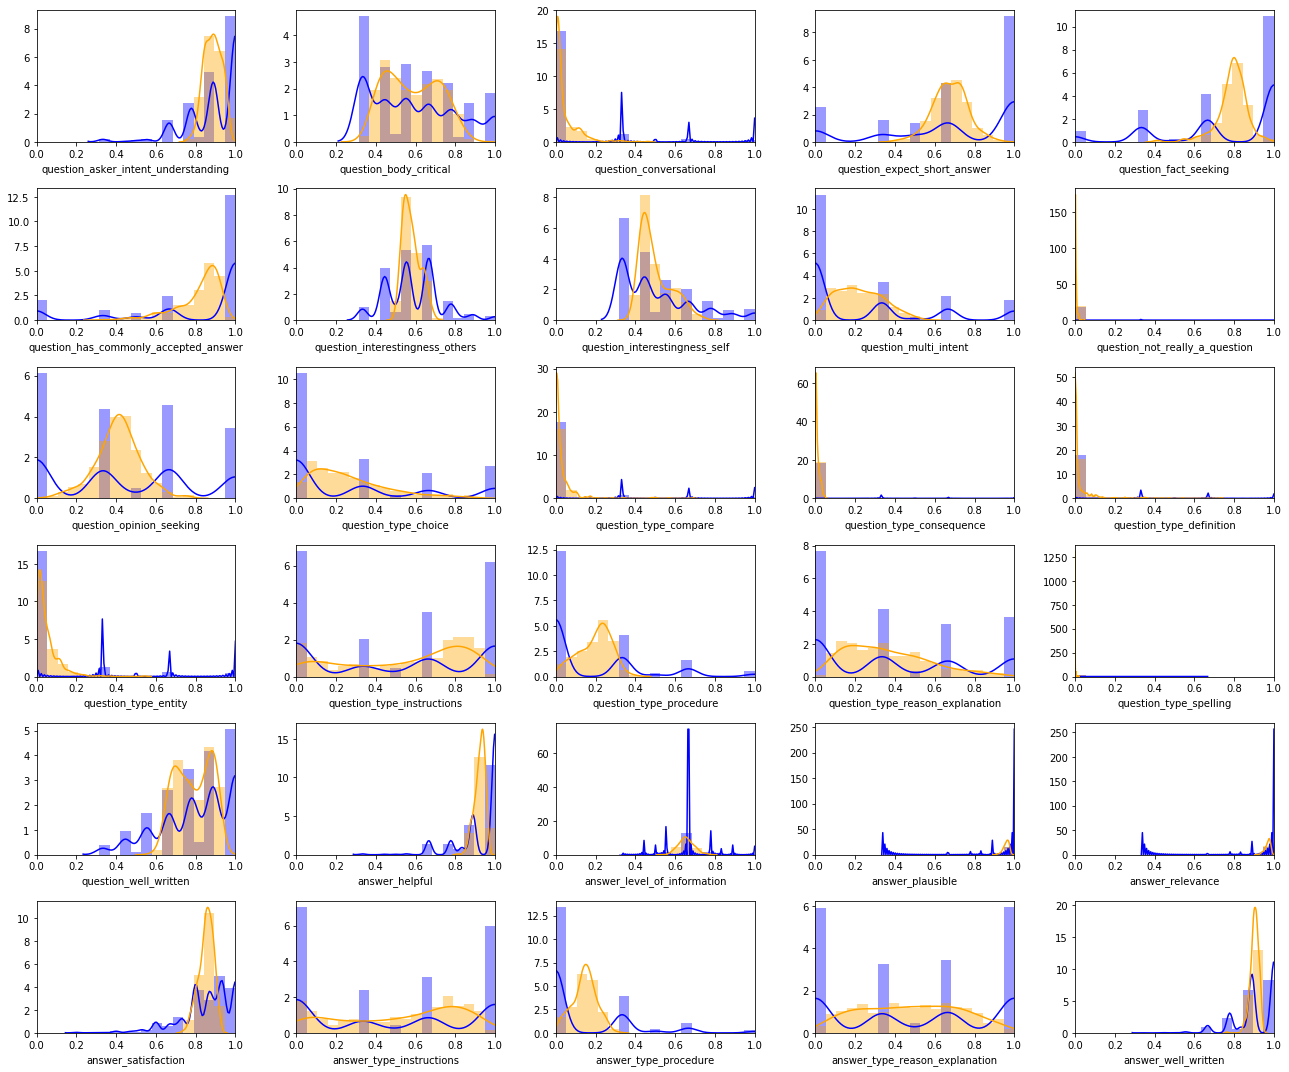

In [30]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(target_cols):
    ax = axes[i]
    sns.distplot(train[col], label=col, bins=bins, ax=ax, color='blue')
    sns.distplot(sub[col], label=col, bins=bins, ax=ax, color='orange')
    # ax.set_title(col)
    ax.set_xlim([0, 1])
plt.tight_layout()
plt.show()
plt.close()